In [6]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import scipy.optimize as spop

from datetime import datetime, timedelta
import os
import asyncio

from binance.client import AsyncClient, HistoricalKlinesType

<h2 style="color: orange">Binance_Batch_Klines_Downloader</h2>

In [17]:
client = await AsyncClient.create()

class Binance_Batch_Klines_Downloader:
  def __init__(self, days_back = 2, interval = "1h", klines_types=[HistoricalKlinesType.FUTURES], rate_limit_ps=2):
    self.days_back = days_back
    self.start = str(datetime.utcnow() - timedelta(days = self.days_back))
    
    self.interval = interval
    self.klines_types = klines_types
    self.rate_limit_ps = rate_limit_ps
    
  def _bars_to_df(self, bars):
    df = pd.DataFrame(bars)
    df["Date"] = pd.to_datetime(df.iloc[:,0], unit = "ms")
    df.columns = ["Open Time", "Open", "High", "Low", "Close", "Volume",
                  "Close Time", "Quote Asset Volume", "Number of Trades",
                  "Taker Buy Base Asset Volume", "Taker Buy Quote Asset Volume", "Ignore", "Date"]
    df = df[["Date", "Open", "High", "Low", "Close", "Volume"]].copy()
    df.set_index("Date", inplace = True)
    for column in df.columns:
        df[column] = pd.to_numeric(df[column], errors = "coerce")
        
    return df
  
  async def _get_symbols(self, klines_type):
    exchange_info = None
    if klines_type == HistoricalKlinesType.FUTURES:
      exchange_info = await client.futures_exchange_info()
    if klines_type == HistoricalKlinesType.SPOT:
      exchange_info = await client.get_exchange_info()
    
    if exchange_info is not None:
      return list(map(lambda x: x['symbol'], exchange_info['symbols']))
  
  async def _download_kline_type(self, klines_type):
    symbols = await self._get_symbols(klines_type)
    if not len(symbols):
      return
    
    new_dir = "Binance_Historical_%s_%s_%i_days_%s" % (self.interval, klines_type.name, self.days_back, str(datetime.utcnow().replace(microsecond=0).isoformat()))
    os.mkdir(new_dir)
    
    chunks = []
    for idx, _ in enumerate(symbols):
      if idx % self.rate_limit_ps == 0:
        symbols_chunk = symbols[idx:idx+self.rate_limit_ps]
        futures_chunk = []
        
        for symbol in symbols_chunk:
          futures_chunk.append(client.get_historical_klines(symbol = symbol, interval = self.interval,
                                        start_str = self.start, end_str = None, limit = 1000, klines_type=klines_type))
          
        chunks.append(futures_chunk)
        
    for index, chunk in enumerate(chunks):
      print("Fetching data for ↓ %s %s" % (klines_type.name, self.interval), "%i / %i" % (index, len(chunks)))
      results = await asyncio.gather(*chunk)
      
      for i, bars in enumerate(results):
        print(symbols[index*self.rate_limit_ps+i])
        try:
          df = self._bars_to_df(bars)
          df.to_csv("%s/%s_%s_%s.csv" % (new_dir, symbols[index*self.rate_limit_ps+i], klines_type.name, self.interval))
        except:
          # print("raw: ", bars)
          print("Couldn't construct DataFrame from raw data for %s" % symbols[index*self.rate_limit_ps+i])
          
  async def download(self):
    for type in self.klines_types:
      print(type)
      await self._download_kline_type(type)

<h2 style="color: orange">DEMO</h2>

In [18]:
downloader = Binance_Batch_Klines_Downloader(days_back=100, interval="1h", klines_types=[HistoricalKlinesType.FUTURES], rate_limit_ps=7)

In [19]:
await downloader.download()

HistoricalKlinesType.FUTURES
Fetching data for ↓ FUTURES 1h 0 / 25
BTCUSDT
ETHUSDT
BCHUSDT
XRPUSDT
EOSUSDT
LTCUSDT
TRXUSDT
Fetching data for ↓ FUTURES 1h 1 / 25
ETCUSDT
LINKUSDT
XLMUSDT
ADAUSDT
XMRUSDT
DASHUSDT
ZECUSDT
Fetching data for ↓ FUTURES 1h 2 / 25
XTZUSDT
BNBUSDT
ATOMUSDT
ONTUSDT
IOTAUSDT
BATUSDT
VETUSDT
Fetching data for ↓ FUTURES 1h 3 / 25
NEOUSDT
QTUMUSDT
IOSTUSDT
THETAUSDT
ALGOUSDT
ZILUSDT
KNCUSDT
Fetching data for ↓ FUTURES 1h 4 / 25
ZRXUSDT
COMPUSDT
OMGUSDT
DOGEUSDT
SXPUSDT
KAVAUSDT
BANDUSDT
Fetching data for ↓ FUTURES 1h 5 / 25


<h2 style="color:lime;">Coint_Analyzer</h2>

In [ ]:
class Coint_Analyzer:
  def __init__(self, dir_paths=["Binance_Historical_1h_FUTURES_100_days_2022-06-26T10:29:34"], observations_low_pass = 2000):
    self.dir_paths = dir_paths
    self.observations_low_pass = observations_low_pass
    
    self.df = None
    self.corr_pairs = None
    self.coint_pairs = None
    self.corr_coint_pairs = None
    
  def process_raw_data(self, dir_paths=None):
    if dir_paths is not None:
      self.dir_paths = dir_paths
    self._closings_csv_to_df()
    self._raw_to_processed()
    self.get_trading_pairs()
  
  def _closings_csv_to_df(self):
    # reading Close values and merging to one DF
    df_closings = pd.DataFrame()
    
    for path in self.dir_paths:
      with os.scandir('raw_data/%s' % path) as entries:
          for entry in entries:
            instrument = "_".join(entry.name.split("_")[0:2])
            df = pd.read_csv('raw_data/%s/%s' % (path, entry.name), index_col="Date")
            df = df[["Close"]].copy()
            df.columns = [instrument]
            df_closings = pd.concat([df_closings, df], axis=1)
    
    # filtering data based on amount of observations in DF
    df_observation_num = pd.DataFrame(columns=["observations"])
    for column in df_closings.columns:
      df_observation_num.loc[column] = len(df_closings[column].dropna())

    drop_columns = []
    for _, row in df_observation_num.iterrows():
      if row.observations < self.observations_low_pass: # arbitrarily selected value based on bottom values from df_observation_num
        drop_columns.append(row.name)
        
    # removing outliers from the original DF
    df_closings.drop(columns=drop_columns, inplace=True)

    # cleaning DF
    df_closings.dropna(inplace=True)
            
    self.df = df_closings
    
  def _raw_to_processed(self):
    # CORRELATION
    if self.df is None:
      return
    
    matrix = self.df.pct_change().corr(method ='pearson')
    matrix.to_excel("processed_data/corr_matrix_temp_%s.xlsx" % str(datetime.utcnow().replace(microsecond=0).isoformat()))
    
    au_corr = matrix.corr().unstack()
    labels_to_drop = self._get_redundant_corr_pairs(matrix)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    au_corr.dropna(inplace=True)
    
    indexes = []
    values = []
    for idx in au_corr.index:
        indexes.append("%s-%s" % (idx[0], idx[1]))
        values.append(au_corr[idx])
    corr_pairs_df = pd.DataFrame(index=indexes, data=values)
    
    self.corr_pairs = corr_pairs_df
    try:
        corr_pairs_df.to_csv("processed_data/corr_pairs__tem%s.csv" % str(datetime.utcnow().replace(microsecond=0).isoformat()))
    except:
      print("Couldn't save pairs to temp files")
      
    # COINTEGRATION 
    _, coint_pairs = self._find_cointegrated_pairs(self.df)
    self.coint_pairs = coint_pairs
    
    
  def _get_redundant_corr_pairs(self, df_corr_matrix):
      '''Get diagonal and lower triangular pairs of correlation matrix'''
      pairs_to_drop = set()
      cols = df_corr_matrix.columns
      for i in range(0, df_corr_matrix.shape[1]):
          for j in range(0, i+1):
              pairs_to_drop.add((cols[i], cols[j]))
      return pairs_to_drop
    
  def _find_cointegrated_pairs(self, df):
    n = df.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = df.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            print("Performing coint test %s %s %s" % (j, i, n))
            result = coint(df[keys[i]], df[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
              # testing for spread stationarity
              model = sm.OLS(df[keys[i]], df[keys[j]])
              results = model.fit()
              hedge_ratio = results.params[0]
              spread = df[keys[i]] - hedge_ratio*df[keys[j]]
              result_adf = adfuller(spread)
              if result_adf[1] < 0.01 and result_adf[0] < result_adf[4]["1%"]:
                pairs.append((keys[i], keys[j], result[1], result_adf[0]))
    try:
        indexes = []
        values = []
        for row in pairs:
            indexes.append("%s-%s" % (row[0], row[1]))
            values.append(row[3])
        coint_pairs_df = pd.DataFrame(index=indexes, data=values)
        coint_pairs_df.sort_values(ascending=True)
        coint_pairs_df.to_csv("processed_data/coint_pairs_temp%s.csv" % str(datetime.utcnow().replace(microsecond=0).isoformat()))
        
        pv_val_df = pd.DataFrame(pvalue_matrix)
        pv_val_df.columns = df.columns
        pv_val_df.index = df.columns
        pv_val_df.to_excel("processed_data/coint_matrix_temp_%s.xlsx" % str(datetime.utcnow().replace(microsecond=0).isoformat()))
    except:
       print("Couldn't save pairs to temp files") 
    return pvalue_matrix, coint_pairs_df
    
  def get_trading_pairs(self, h_pass = 0.94, corr_path = None, coint_path = None):
    df_corr = None
    df_coint = None
    if corr_path is not None and coint_path is not None:
      df_corr = pd.read_csv(corr_path)
      df_coint = pd.read_csv(coint_path)
    elif self.corr_pairs is not None and self.coint_pairs is not None:
      df_corr = self.corr_pairs.copy()
      df_coint = self.coint_pairs.copy()
      
    if df_corr is None or df_coint is None:
      return
    
    df_hi_corr = df_corr.loc[df_corr[0]>h_pass]
    df_corr_coint_pairs = pd.DataFrame(columns=["corr", "coint"])
    for idx in df_hi_corr.index:
      if idx in df_coint.index:
        df_corr_coint_pairs.loc[idx] = [df_hi_corr.loc[idx][0], df_coint.loc[idx][0]]
        
    self.corr_coint_pairs = df_corr_coint_pairs
    try:
      df_corr_coint_pairs.to_csv("processed_data/corr_coint_pairs_temp_%s.csv" % str(datetime.utcnow().replace(microsecond=0).isoformat()))
    except:
      print("Data couldn't be stored in a static file.")
    return df_corr_coint_pairs
    

<h2 style="color:lime;">DEMO</h2>

In [ ]:
analyzer = Coint_Analyzer()

In [ ]:
analyzer.process_raw_data()

In [ ]:
analyzer.get_trading_pairs()

,corr,coint
SOLBUSD_FUTURES-SOLUSDT_FUTURES,0.999969,-4.799116
ADABUSD_FUTURES-ADAUSDT_FUTURES,0.999961,-4.367090
DOGEUSDT_FUTURES-DOGEBUSD_FUTURES,0.999949,-5.106769
ETHUSDT_FUTURES-ETHBUSD_FUTURES,0.999933,-5.623721
XRPBUSD_FUTURES-XRPUSDT_FUTURES,0.999922,-4.553645
...,...,...
ZRXUSDT_FUTURES-SOLBUSD_FUTURES,0.940238,-3.462586
ZILUSDT_FUTURES-ONTUSDT_FUTURES,0.940177,-4.591037
ATAUSDT_FUTURES-BAKEUSDT_FUTURES,0.940171,-4.065521
OMGUSDT_FUTURES-DOGEUSDT_FUTURES,0.940152,-4.140125


<h2 style="color:salmon">Backtester</h2>

In [186]:
class Backtester:
  def __init__(self, dir_name, data_interval, pair, tc):
    self.dir_name = dir_name
    self.data_interval = data_interval
    self.pair = pair
    self.tc = tc
    
    self.results = None
    self.data = None
    self.tp_year = None
    
    self._get_data()
    
    
  def __repr__(self):
      return "Pairs trading backtester(INSTRUMENTS = {} / {})".format(self.pair[0], self.pair[1])
        
  def _get_data(self):
    entries = []
    for instrument in self.pair:
      entries.append("%s_%s.csv" % (instrument, self.data_interval))
      
    df_closings = pd.DataFrame()
    for entry in entries:
      instrument = "_".join(entry.split("_")[0:2])
      df = pd.read_csv('raw_data/%s/%s' % (self.dir_name, entry), index_col="Date", parse_dates=["Date"])
      df = df[["Close"]].copy()
      df.columns = [instrument]
      df["%s_returns" % instrument] = np.log(df[instrument]/df[instrument].shift(1))
      df_closings = pd.concat([df_closings, df], axis=1)
      
      
    df_closings.dropna(inplace=True)
    self.data = df_closings
    self.tp_year = (self.data.shape[0] / ((self.data.index[-1] - self.data.index[0]).days / 365.25))
    
    return df_closings
    
  def test_strategy(self, window=98*20, spread_entry=0.05, tp=0, sl=0, critical_threshold = -2.4, unbiased_adf=True):
    inst1 = self.pair[0]
    inst2 = self.pair[1]
    
    data = self.data.copy()
    data["signals"] =  0
    data["%s_position" % inst1] = 0
    data["%s_position" % inst2] = 0
    data["gross_returns"] = 0
    data["net_returns"] = 0
    
    signal = 0
    old_signal = 0
    current_return = 0
    position0 = 0
    position1 = 0

    #moving through the sample
    for t in range(window, len(data)-1):
      df_adfuller = pd.DataFrame()
      
      # because of sampling index is off when sample[t]
      sample = data.iloc[t-window:t+1].copy()
      
      old_signal = signal
      old_position0 = position0
      old_position1 = position1
      gross = 0
      net = 0
      
      if unbiased_adf is True:
        def unit_root(b):
            a = np.average(sample[inst2] - b*sample[inst1])
            df_adfuller["fair_value"] = a + b*sample[inst1]
            df_adfuller["diff_fair"] = df_adfuller["fair_value"] - sample[inst2]
            df_adfuller["delta_diff_fair"] = df_adfuller["diff_fair"]/df_adfuller["diff_fair"].shift(1)
            df_adfuller["lag_diff_fair"] = df_adfuller["diff_fair"].shift()
            
            # LAGS (augmentation)
            # df_adfuller["lag1_delta_diff_fair"] = df_adfuller["delta_diff_fair"].shift(1)
            # df_adfuller["lag2_delta_diff_fair"] = df_adfuller["delta_diff_fair"].shift(2)
            
            df_adfuller.dropna(inplace=True)
            #OLS(dependent, independent)
            reg = sm.OLS(df_adfuller["delta_diff_fair"], df_adfuller[["lag_diff_fair"]]) #, "lag1_delta_diff_fair", "lag2_delta_diff_fair"
            res = reg.fit()
            return res.params[0]/res.bse[0]
          
        # starting point
        reg = sm.OLS(np.array(sample[inst2]), sm.add_constant(sample[inst1]))
        res = reg.fit()
        b0 = res.params[1]
        
        # optimising the cointegration equation parameters - method most probably can be more performant one
        res1 = spop.minimize(unit_root, b0, method='Nelder-Mead')
        t_opt = res1.fun
        b_opt = float(res1.x)
        a_opt = np.average(sample[inst2] - b_opt*sample[inst1])
        
        # Z-Score based entries
        # sample["fair_value"] = a_opt + b_opt*sample[inst1]
        # sample["fair_spread"] = sample["fair_value"] - sample[inst2]
        # spread_mean = np.mean(sample["fair_spread"])
        # spread_std = np.std(sample["fair_spread"])
        # # investigate the curvature of the z_score in comparison to spread
        # sample["z_score"] = (sample["fair_spread"]-spread_mean)/spread_std
      else:
        print("BIASED ADFULLER")
      
      #simulating trading
      fair_value = a_opt + b_opt*sample[inst1].iloc[window]
      spread = fair_value-sample[inst2].iloc[window]
      
      # print(t, fair_value, spread, t_opt, signal)
      
      if t_opt > critical_threshold:
        signal = 0
        gross = 0
      else:
        ##########################################
        # LOGIC BELOW HAS TO BE REFINED ##########
        ##########################################
        # VVVVVVVVVVVVVVVVVVVVVVVVVVVVV ##########
        ##########################################
        # there is no actual position exit logic #
        ##########################################
        
        if signal == 0:
          if abs(spread) > spread_entry:
            signal = np.sign(fair_value - sample[inst2].iloc[window])
          # return # 2xcheck if it works correctly
        if signal != 0:
          if sl != 0 and current_return < sl:
            signal = 0
            # return # 2xcheck if it works correctly
          if tp !=0 and current_return > tp:
            signal = 0
            # return
          if abs(spread) > spread_entry:
            # should time shifting(1) be implemented here?
            # it is an INTEGER, lol xd
            signal = np.sign(fair_value - sample[inst2].iloc[window])
          
        position0 = signal
        position1 = -signal
      
        # gross = position0*(sample[inst1][t+1]/sample[inst1][t] - 1) + position1*(sample[inst2[1]][t+1]/sample[inst2[1]][t] - 1)
        gross = position0*sample["%s_returns" % inst1][window] + position1*sample["%s_returns" % inst2][window]
        net = gross - self.tc*(abs(position0 - old_position0) + abs(position1 - old_position1))
        if signal == old_signal:
          current_return = (1+current_return)*(1+gross)-1
        else:
          current_return = gross
        
        
        # adfuller data could also be assigned below
        data.loc[[data.index[t]], ["%s_position" % inst1]] = position0
        data.loc[[data.index[t]], ["%s_position" % inst2]] = position1
        data.loc[[data.index[t]], ["gross_returns"] ] = gross
        data.loc[[data.index[t]], ["net_returns"]] = net
    
        #interface: reporting daily positions and realised returns
        print('day '+str(data.index[t]), t, "/", len(data)-1)
        print('')
        if signal == 0:
            print('no trading')
        elif  signal == 1:
            print('long position on '+inst2+' and short position on '+inst1)
        else:
            print('long position on '+inst1+' and short position on '+inst2)
        print('gross daily return: '+str(round(gross*100,2))+'%')
        print('net daily return: '+str(round(net*100,2))+'%')
        print('cumulative net return so far: '+str(round(np.prod(1+data["net_returns"])*100-100,2))+'%')
        print('')
        
    self.results = data
        
    #plotting equity curves
    # plt.plot(np.append(1,np.cumprod(1+data["gross_returns"])))
    # plt.plot(np.append(1,np.cumprod(1+data["net_returns"])))

<h2 style="color:salmon">DEMO</h2>

In [187]:
backtester = Backtester(pair=["ENJUSDT_FUTURES", "BAKEUSDT_FUTURES"], dir_name="Binance_Historical_1h_FUTURES_100_days_2022-06-26T10:29:34", data_interval="1h", tc=0.004)

In [188]:
backtester

Pairs trading backtester(INSTRUMENTS = ENJUSDT_FUTURES / BAKEUSDT_FUTURES)

In [189]:
backtester.test_strategy()

day 2022-06-08 04:00:00 1960 / 2398

no trading
gross daily return: 0.0%
net daily return: 0.0%
cumulative net return so far: 0%

day 2022-06-08 05:00:00 1961 / 2398

long position on ENJUSDT_FUTURES and short position on BAKEUSDT_FUTURES
gross daily return: -0.67%
net daily return: -1.47%
cumulative net return so far: -1.47%

day 2022-06-08 06:00:00 1962 / 2398

long position on ENJUSDT_FUTURES and short position on BAKEUSDT_FUTURES
gross daily return: -0.52%
net daily return: -0.52%
cumulative net return so far: -1.98%

day 2022-06-08 07:00:00 1963 / 2398

long position on ENJUSDT_FUTURES and short position on BAKEUSDT_FUTURES
gross daily return: 2.74%
net daily return: 2.74%
cumulative net return so far: 0.71%

day 2022-06-08 08:00:00 1964 / 2398

long position on ENJUSDT_FUTURES and short position on BAKEUSDT_FUTURES
gross daily return: 4.25%
net daily return: 4.25%
cumulative net return so far: 4.98%

day 2022-06-08 09:00:00 1965 / 2398

long position on ENJUSDT_FUTURES and short 

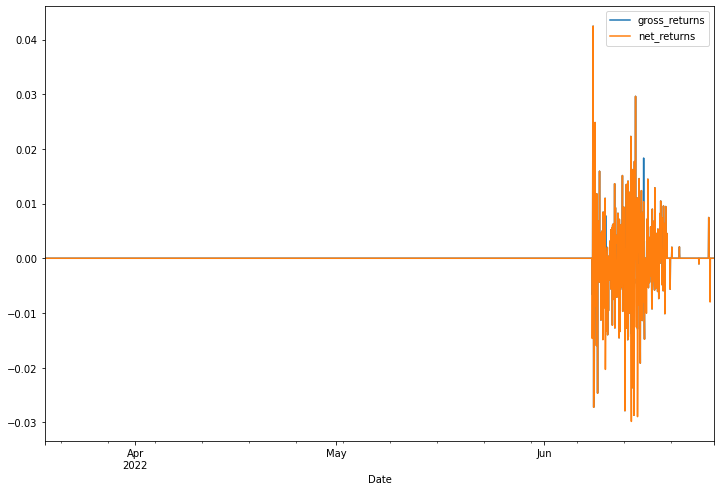

In [191]:
backtester.results[["gross_returns", "net_returns"]].plot(figsize=(12, 8))
plt.show()

In [55]:
dir_name="Binance_Historical_1h_FUTURES_100_days_2022-06-26T10:29:34"
pair=["ENJUSDT_FUTURES", "BAKEUSDT_FUTURES"]
entries = []
for instrument in pair:
  entries.append("%s_%s.csv" % (instrument, "1h"))

df_closings = pd.DataFrame()
for entry in entries:
  instrument = "_".join(entry.split("_")[0:2])
  df = pd.read_csv('raw_data/%s/%s' % (dir_name, entry), index_col="Date", parse_dates=["Date"])
  df = df[["Close"]].copy()
  df.columns = [instrument]
  df["%s_returns" % instrument] = np.log(df[instrument]/df[instrument].shift(1))
  df_closings = pd.concat([df_closings, df], axis=1)
  
      
df_closings.dropna(inplace=True)

In [161]:
df_closings.index[2]

Timestamp('2022-03-18 14:00:00')

In [60]:
df_adfuller = pd.DataFrame()
sample = df_closings.iloc[0:2000].copy()
inst1 = pair[0]
inst2 = pair[1]

def unit_root(b):
  a = np.average(sample[inst2] - b*sample[inst1])
  df_adfuller["fair_value"] = a + b*sample[inst1]
  df_adfuller["diff_fair"] = df_adfuller["fair_value"] - sample[inst2]
  df_adfuller["delta_diff_fair"] = df_adfuller["diff_fair"]/df_adfuller["diff_fair"].shift(1)
  df_adfuller["lag_diff_fair"] = df_adfuller["diff_fair"].shift()
  # LAGS (augmentation)
  df_adfuller["lag1_delta_diff_fair"] = df_adfuller["delta_diff_fair"].shift(1)
  df_adfuller["lag2_delta_diff_fair"] = df_adfuller["delta_diff_fair"].shift(2)
  
  df_adfuller.dropna(inplace=True)
  #OLS(dependent, independent) - add lags to the independent
  reg = sm.OLS(df_adfuller["delta_diff_fair"], df_adfuller[["lag_diff_fair", "lag1_delta_diff_fair", "lag2_delta_diff_fair"]])
  res = reg.fit()
  return res.params[0] / res.bse[0]

# why I use np array & add_constant ??

reg = sm.OLS(np.array(sample[inst2]), sm.add_constant(sample[inst1]))
res = reg.fit()
a0 = res.params[0]
b0 = res.params[1]

unit_root(b0)

res1 = spop.minimize(unit_root, b0, method='Nelder-Mead')
t_opt = res1.fun
b_opt = float(res1.x)
a_opt = np.average(sample[inst2] - b_opt*sample[inst1])

sample["fair_value"] = a_opt + b_opt*sample[inst1]
sample["fair_spread"] = sample["fair_value"] - sample[inst2]
spread_mean = np.mean(sample["fair_spread"])
spread_std = np.std(sample["fair_spread"])
# investigate the curvature of the z_score in comparison to spread
sample["z_score"] = (sample["fair_spread"]-spread_mean)/spread_std

fair_value = a_opt + b_opt*sample[inst1].iloc[1]
spread = fair_value-sample[inst2].iloc[1]


In [61]:
fair_value

0.718851202557804

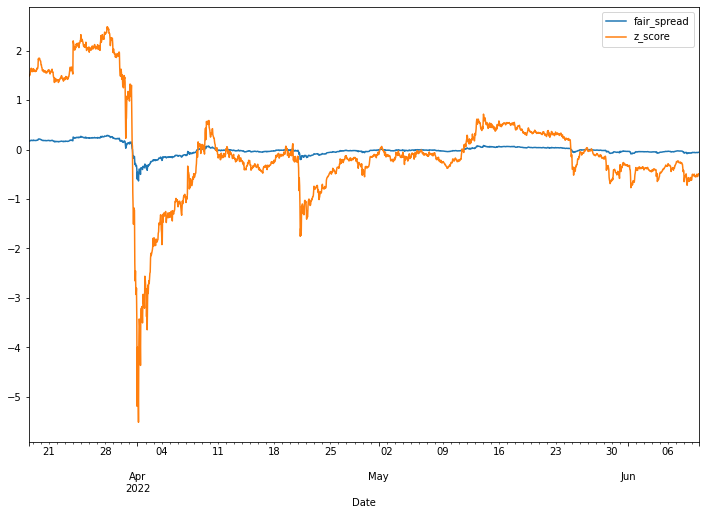

In [39]:
sample.fair_spread.plot(figsize=(12, 8))
sample.z_score.plot()
plt.legend()
plt.show()

In [37]:
type(abs(-2*2))

int